In [66]:
import time
import random
import copy
from collections import namedtuple, defaultdict
from subprocess import Popen
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
np.set_printoptions(precision=0)

from chord_utils import *
import elia_lrde_chords
import dale_kojas_chords
import kriste_aghsdga_chords

In [71]:
# get ratios
def get_ratios():
    def normalize(r):
        n = [r[0], r[1]]
        while 2 <= n[0] / n[1]:
            n[1] *= 2
        while n[0] / n[1] <= 1:
            n[0] *= 2
        return tuple(n)

    # wilson41
    # crystal growth algorithm
    primes = [3, 5, 7, 11, 13]
    ratios = [(1, 1), (2, 1)]
    for i, p in enumerate(primes):
        if p == 13:
            break
        r1 = [p, 1]

        max_deg = len(primes) - i
        if p == 3:
            max_deg -= 1
        for j in range(max_deg):
            ratios.append(normalize(tuple(r1)))
            r1i = [r1[1], r1[0]]
            ratios.append(normalize(tuple(r1i)))
            r1[0] *= 3
        if p == 3:
            continue
        r1 = [p, 3]
        for j in range(1, max_deg):
            ratios.append(normalize(tuple(r1)))
            r1i = [r1[1], r1[0]]
            ratios.append(normalize(tuple(r1i)))
            r1[1] *= 3

    odds = [1, 3, 5, 7, 9, 11]
    for p1 in odds:
        for p2 in odds:
            if p1 == p2:
                continue
            if min(p1, p2) != 1 and (max(p1, p2) % min(p1, p2) == 0):
                continue
            # wilson example
            # if (p1, p2) in [(11, 5), (5, 11)]:
                # continue
            r = (p1, p2)
            r = normalize(r)
            if r not in ratios:
                ratios.append(r)

    # ratios.sort(key=lambda r: util.ratio_to_cents(r[0], r[1]))
    return ratios

ratios = get_ratios()
print('ratios count', len(ratios))
print(ratios)

ratios count 48
[(1, 1), (2, 1), (3, 2), (4, 3), (9, 8), (16, 9), (27, 16), (32, 27), (81, 64), (128, 81), (5, 4), (8, 5), (15, 8), (16, 15), (45, 32), (64, 45), (135, 128), (256, 135), (5, 3), (6, 5), (10, 9), (9, 5), (40, 27), (27, 20), (7, 4), (8, 7), (21, 16), (32, 21), (63, 32), (64, 63), (7, 6), (12, 7), (14, 9), (9, 7), (11, 8), (16, 11), (33, 32), (64, 33), (11, 6), (12, 11), (10, 7), (20, 11), (7, 5), (14, 11), (18, 11), (11, 10), (11, 7), (11, 9)]


In [72]:
def get_peaks(bin_pitches, bin_heights, window_size):
    assert(len(bin_heights) == len(bin_pitches))
    peaks = []
    persistences = []
    for i in range(len(bin_pitches)):
        is_max = True
        persistence = 0
        for k in range(-window_size, window_size + 1):
            if i + k < 0:
                is_max = False
            if i + k >= len(bin_pitches):
                is_max = False
            if k == 0 or not is_max:
                continue
            if bin_heights[i] <= bin_heights[i + k]:
                is_max = False
            persistence += (bin_heights[i] - bin_heights[i + k])
        if is_max:
            peaks.append(i)
            persistences.append(-persistence)
    peaks = [x for _, x in sorted(zip(persistences, peaks))]
    return peaks

def draw_peaks(peaks, bin_pitches, bin_heights, peak_count, pitch_diff):
    x = []
    ymin = []
    ymax = []
    idx = -1
    while len(x) < peak_count:
        idx += 1
        if idx >= len(peaks):
            break
        b = peaks[idx]#.born
        p = bin_pitches[b]
        found_near_pitch = False
        for prev_p in x:
            if abs(p - prev_p) < pitch_diff:
                found_near_pitch = True
                break
        if found_near_pitch:
            continue
        print(p, b)#, peaks[idx].left, peaks[idx].right, peaks[idx].died, bin_heights[b])
        x.append(p)
        ymin.append(0)
        ymax.append(bin_heights[b])
        plt.text(p + 10, bin_heights[b], len(x), fontsize=20)
    plt.vlines(x, ymin, ymax, colors='r')
    plt.show()
    return x


In [74]:
TimestampChord = namedtuple('TimestampChord', ['pitches', 'timestamp'])

def get_song(chords_source, chord_type):
#     print('new song')
    pre_song = []
    chords = chords_source.get_chords()
    for i, chord in enumerate(chords):
        if chord_type == 'gvm':
            pitches = chord.gvm
        else:
            assert(chord_type == 'tony')
            pitches = chord.tony
        pre_song.append(TimestampChord(pitches, chord.timestamp))
    song = []
    for i in range(len(pre_song) - 1):
        if pre_song[i + 1].timestamp - pre_song[i].timestamp > 0.5:
            song.append(pre_song[i])
#         print(pitches, chord.syllable, chord.timestamp)
#     print()
#     print()
#     print()
    return song

songs = []
songs.append(get_song(elia_lrde_chords, 'tony'))
songs.append(get_song(dale_kojas_chords, 'gvm'))
songs.append(get_song(kriste_aghsdga_chords, 'gvm'))
print(sum([len(song) for song in songs]))

182


In [75]:
ref_hz = 55

cents = [[], [], []]
all_cents = []

relative_cents = [[], [], []]
all_relative_cents = []

intervals = [[], [], []]
all_intervals = []

cents_tolerance = 10
intervals_as_ji = dict()

all_chords = []

abs_steps = [[], [], []]
all_abs_steps = []

steps = [[], [], []]
all_steps = []

# todo: distribute these comments into code
# collect pitches
# todo: retrieve tonic
# todo: collect pitches relative to tonic
# collect intervals; analyze them as JI
# collect chords
# collect also musical steps

for song in songs:
    tonic = (song[-2].pitches[0] + song[-2].pitches[1]) / 2
    if abs(np.mean(song[-2].pitches) - tonic) < 10:
        tonic = np.mean(song[-2].pitches)
    tonic_in_hz = calc_hz(tonic, ref_hz)
    for ch_idx, chord in enumerate(song):
#         if ch_idx < len(song) * 0.5:
#             continue
        assert(len(chord.pitches) == 3)
        pitches = []
        for p_idx, pitch in enumerate(chord.pitches):
            if pitch is None:
                continue
            cents[p_idx].append(pitch)
            all_cents.append(pitch)
            pitches.append(pitch)
            pitch_in_hz = calc_hz(pitch, ref_hz)
            relative_pitch = round(ratio_to_cents(pitch_in_hz, tonic_in_hz))
            relative_cents[p_idx].append(relative_pitch)
            all_relative_cents.append(relative_pitch)

        # chord intervals
        if len(pitches) == 0:
            continue
        elif len(pitches) == 1:
            diffs = []
        elif len(pitches) == 2:
            diffs = [pitches[1] - pitches[0]]
        else:
            diffs = [pitches[2] - pitches[0],
                     pitches[2] - pitches[1],
                     pitches[1] - pitches[0]]
            for k in range(3):
                intervals[k].append(diffs[k])
                all_intervals.append(diffs[k])
            ch = tuple(diffs)
            all_chords.append(ch)

        diffs = [abs(c) for c in diffs]
        notes = []
        for i, p in enumerate(diffs):
            n = str(diffs[i]) + 'c'
            state = ''
            for r in ratios:
                c1 = diffs[i]
                c2 = ratio_to_cents(r[0], r[1])
                check1 = abs(c1 - c2) < cents_tolerance
                check2 = abs(c1 - c2) < cents_tolerance * 1.5
                add = ''
                if check2 and not check1:
                    add = '?'
                if check2:
                    if r == (1, 1):
                        state = '.' + add
                    else:
                        state = 'ji'
                        n += ' ' + add + str(r[0]) + '/' + str(r[1])
            notes.append((n, state))

        if len(diffs) == 3:
            for k in range(3):
                pretty = ' '.join(notes[k][0].split(' ')[1:])
                intervals_as_ji[diffs[k]] = pretty + ' ' + notes[k][1]

    for voice in range(3):
        prev_pitch = None
        for chord in song:
            cur_pitch = chord.pitches[voice]
            if prev_pitch is not None and cur_pitch is not None:
                step = cur_pitch - prev_pitch
                steps[voice].append(step)
                all_steps.append(step)
                abs_steps[voice].append(abs(step))
                all_abs_steps.append(abs(step))
            prev_pitch = cur_pitch

print(len(all_chords))

158


accuracy 10.058823529411764
2555.615015453764 116
2361.9931747937435 92
2063.4928371095457 55
2870.2505065262976 155
2942.8586967738047 164
1845.6682663670226 28
2749.2368561137846 140
2652.4259357837745 128
3096.1426539629874 183
2015.0873769445404 49
1676.2491557895048 7
2216.7767942987284 74
2426.533788347084 100
3184.8859975988307 194
3015.4668870213127 173
1789.19522950785 21
1910.2088799203627 36
2265.1822544637334 80


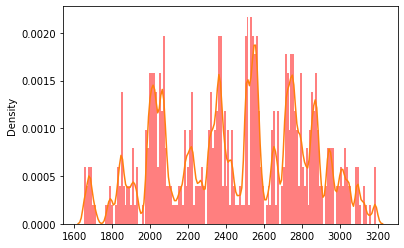

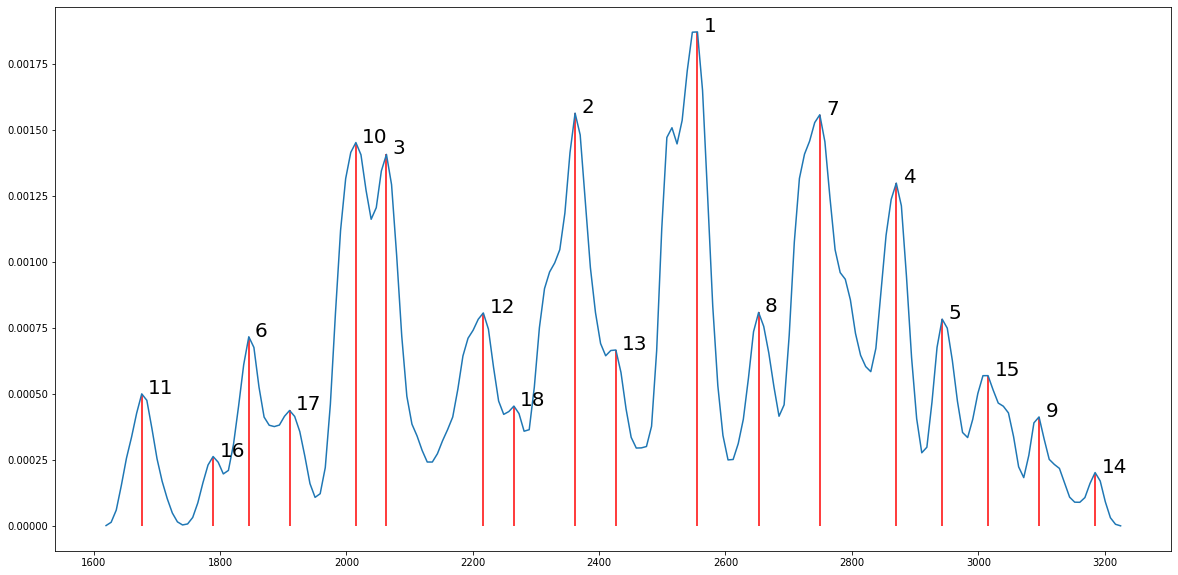

[2555, 2361, 2063, 2870, 2942, 1845, 2749, 2652, 3096, 2015, 1676, 2216, 2426, 3184, 3015, 1789, 1910, 2265]


array([[    0,   194,   492,  -315,  -387,   710,  -194,   -97,  -541,
          540,   879,   339,   129,  -629,  -460,   766,   645,   290],
       [ -194,     0,   298,  -509,  -581,   516,  -388,  -291,  -735,
          346,   685,   145,   -65,  -823,  -654,   572,   451,    96],
       [ -492,  -298,     0,  -807,  -879,   218,  -686,  -589, -1033,
           48,   387,  -153,  -363, -1121,  -952,   274,   153,  -202],
       [  315,   509,   807,     0,   -72,  1025,   121,   218,  -226,
          855,  1194,   654,   444,  -314,  -145,  1081,   960,   605],
       [  387,   581,   879,    72,     0,  1097,   193,   290,  -154,
          927,  1266,   726,   516,  -242,   -73,  1153,  1032,   677],
       [ -710,  -516,  -218, -1025, -1097,     0,  -904,  -807, -1251,
         -170,   169,  -371,  -581, -1339, -1170,    56,   -65,  -420],
       [  194,   388,   686,  -121,  -193,   904,     0,    97,  -347,
          734,  1073,   533,   323,  -435,  -266,   960,   839,   484],

In [40]:
datum = all_cents
num_bins = int((max(datum) - min(datum)) / 10)
print('accuracy', (max(datum) - min(datum)) / num_bins)
h = plt.hist(datum, num_bins,
             density=True,
             histtype='bar',
             facecolor='r',
             alpha=0.5)

kde = sns.kdeplot(np.array(datum), bw_method=0.03)

xs = kde.get_lines()[0].get_xdata(orig=True)
ys = kde.get_lines()[0].get_ydata(orig=True)
plt.figure(figsize=(20, 10))
plt.plot(xs, ys)

peaks = get_peaks(xs, ys, 2)
x = draw_peaks(peaks, xs, ys, 20, 40)

int_ps = [int(p) for p in x]
print(int_ps)
(np.array(int_ps).reshape(-1, 1) - int_ps)

accuracy 9.02061855670103
16.12332287903996 74
691.9223074653559 148
253.56620935531305 100
975.0272874947583 179
472.7442584103345 124
171.3744409596801 91
317.49314032969426 107
-385.70310038849925 30
-38.671189384715376 68
737.5844010184852 153
783.2464945716148 158
-120.86295778034844 59
-203.05472617598144 50
1038.9542184691395 186
-276.1140758609886 42
-477.0272874947581 20
107.44750998529878 84
573.2008642272193 135
-623.1459868647723 4
1121.1459868647726 195


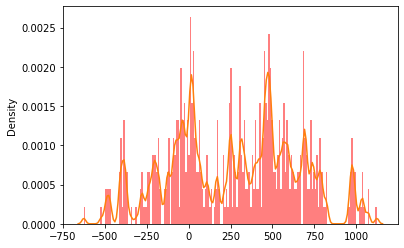

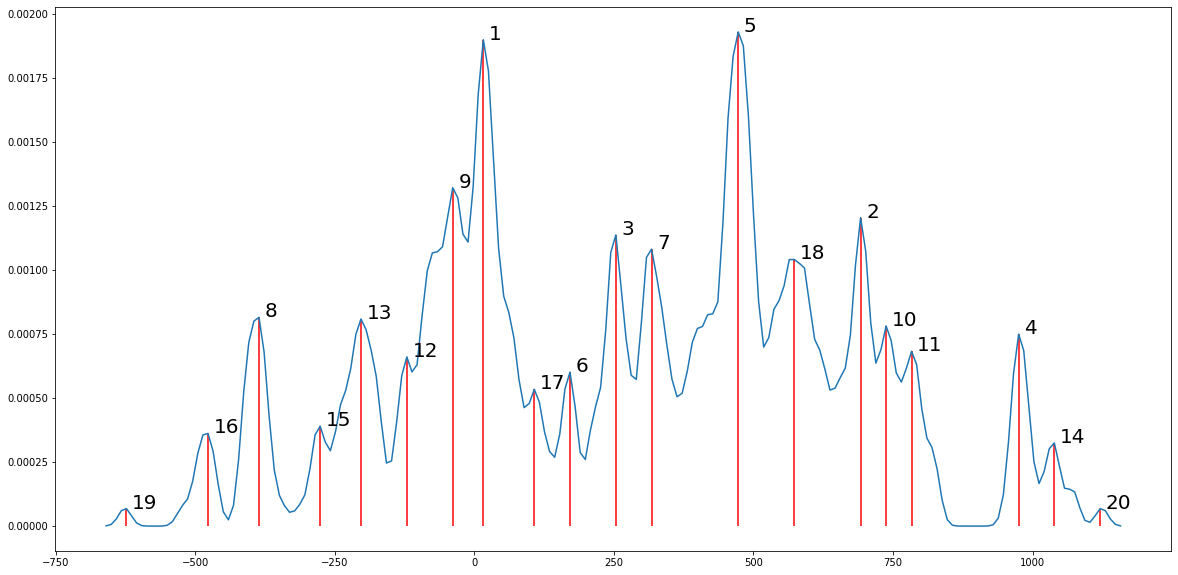

[16, 691, 253, 975, 472, 171, 317, -385, -38, 737, 783, -120, -203, 1038, -276, -477, 107, 573, -623, 1121]


array([[    0,  -675,  -237,  -959,  -456,  -155,  -301,   401,    54,
         -721,  -767,   136,   219, -1022,   292,   493,   -91,  -557,
          639, -1105],
       [  675,     0,   438,  -284,   219,   520,   374,  1076,   729,
          -46,   -92,   811,   894,  -347,   967,  1168,   584,   118,
         1314,  -430],
       [  237,  -438,     0,  -722,  -219,    82,   -64,   638,   291,
         -484,  -530,   373,   456,  -785,   529,   730,   146,  -320,
          876,  -868],
       [  959,   284,   722,     0,   503,   804,   658,  1360,  1013,
          238,   192,  1095,  1178,   -63,  1251,  1452,   868,   402,
         1598,  -146],
       [  456,  -219,   219,  -503,     0,   301,   155,   857,   510,
         -265,  -311,   592,   675,  -566,   748,   949,   365,  -101,
         1095,  -649],
       [  155,  -520,   -82,  -804,  -301,     0,  -146,   556,   209,
         -566,  -612,   291,   374,  -867,   447,   648,    64,  -402,
          794,  -950],
       [  

In [41]:
datum = all_relative_cents
num_bins = int((max(datum) - min(datum)) / 9)
print('accuracy', (max(datum) - min(datum)) / num_bins)
h = plt.hist(datum, num_bins,
             density=True,
             histtype='bar',
             facecolor='r',
             alpha=0.5)

kde = sns.kdeplot(np.array(datum), bw_method=0.03)

xs = kde.get_lines()[0].get_xdata(orig=True)
ys = kde.get_lines()[0].get_ydata(orig=True)
plt.figure(figsize=(20, 10))
plt.plot(xs, ys)

peaks = get_peaks(xs, ys, 2)
x = draw_peaks(peaks, xs, ys, 20, 10)

int_ps = [int(p) for p in x]
print(int_ps)
(np.array(int_ps).reshape(-1, 1) - int_ps)

accuracy 5.007905138339921
2.470295044002796 90
-186.88354113746243 61
152.64747546378555 113
-160.76577062967414 65
204.88301647936214 121
342.0013116452508 142
-271.7662952877744 48
106.94137707515608 106
-102.00078698715043 74
257.11855749493884 129
-369.70793469198054 33
-506.8262298578692 12
-75.88301647936214 78
-402.35514782671595 28
-350.11960681113936 36
668.4734429926046 192
472.5901641841923 162
-565.5912135003929 3
518.2962625728218 169
-480.7084593500809 16


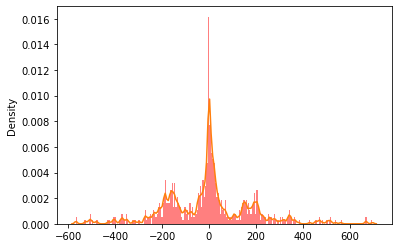

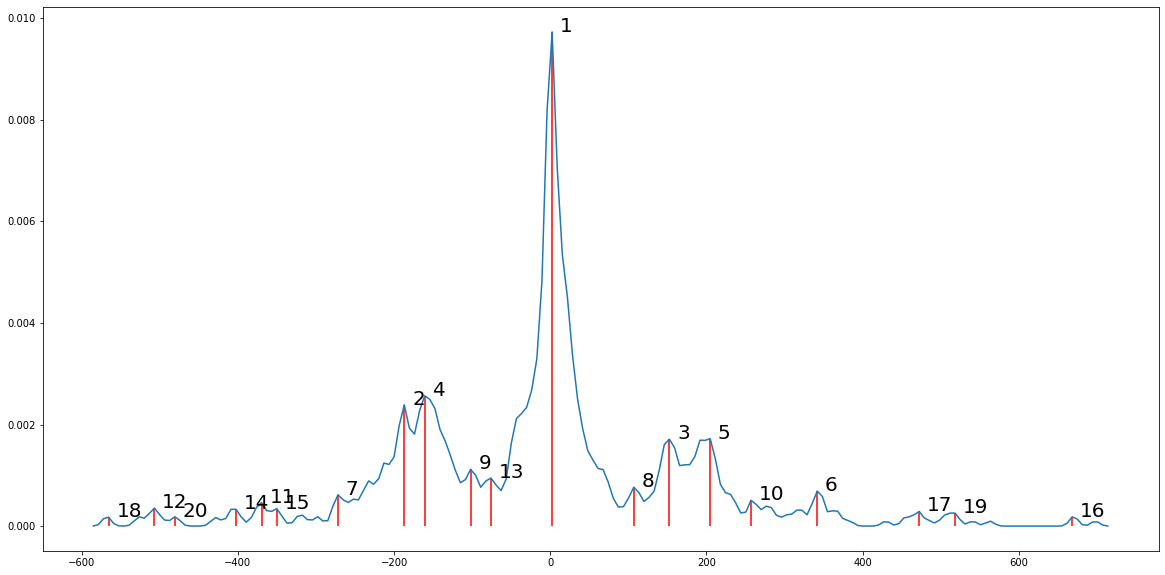

[2, -186, 152, -160, 204, 342, -271, 106, -102, 257, -369, -506, -75, -402, -350, 668, 472, -565, 518, -480]


array([[    0,   188,  -150,   162,  -202,  -340,   273,  -104,   104,
         -255,   371,   508,    77,   404,   352,  -666,  -470,   567,
         -516,   482],
       [ -188,     0,  -338,   -26,  -390,  -528,    85,  -292,   -84,
         -443,   183,   320,  -111,   216,   164,  -854,  -658,   379,
         -704,   294],
       [  150,   338,     0,   312,   -52,  -190,   423,    46,   254,
         -105,   521,   658,   227,   554,   502,  -516,  -320,   717,
         -366,   632],
       [ -162,    26,  -312,     0,  -364,  -502,   111,  -266,   -58,
         -417,   209,   346,   -85,   242,   190,  -828,  -632,   405,
         -678,   320],
       [  202,   390,    52,   364,     0,  -138,   475,    98,   306,
          -53,   573,   710,   279,   606,   554,  -464,  -268,   769,
         -314,   684],
       [  340,   528,   190,   502,   138,     0,   613,   236,   444,
           85,   711,   848,   417,   744,   692,  -326,  -130,   907,
         -176,   822],
       [ -

In [33]:
datum = all_steps
num_bins = int((max(datum) - min(datum)) / 5)
print('accuracy', (max(datum) - min(datum)) / num_bins)
h = plt.hist(datum, num_bins,
             density=True,
             histtype='bar',
             facecolor='r',
             alpha=0.5)

kde = sns.kdeplot(np.array(datum), bw_method=0.03)

xs = kde.get_lines()[0].get_xdata(orig=True)
ys = kde.get_lines()[0].get_ydata(orig=True)
plt.figure(figsize=(20, 10))
plt.plot(xs, ys)

peaks = get_peaks(xs, ys, 2)
x = draw_peaks(peaks, xs, ys, 20, 10)

int_ps = [int(p) for p in x]
print(int_ps)
(np.array(int_ps).reshape(-1, 1) - int_ps)

In [22]:
names = ['elia', 'dale', 'krst']
s_idx = 0
print(names[s_idx], songs[s_idx][0].pitches, songs[s_idx][-2].pitches)
s_idx = 1
print(names[s_idx], songs[s_idx][0].pitches, songs[s_idx][-2].pitches)
s_idx = 2
print(names[s_idx], songs[s_idx][0].pitches, songs[s_idx][-2].pitches)

elia [None, 2616, None] [2004, 2029, 2724]


IndexError: list index out of range

accuracy 10.0
2.7048874911930483 10
698.1506594287029 113
502.3455391744525 84
232.26951123755552 44
380.8113266028488 66
1083.008999238781 170
340.29992241231434 60
1035.745694349824 163
866.9481768892634 138
1211.295112508807 189
1150.5280062230051 180
76.97579517383971 21
941.2190845719101 149


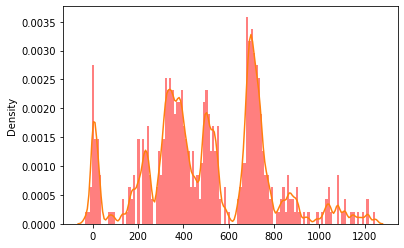

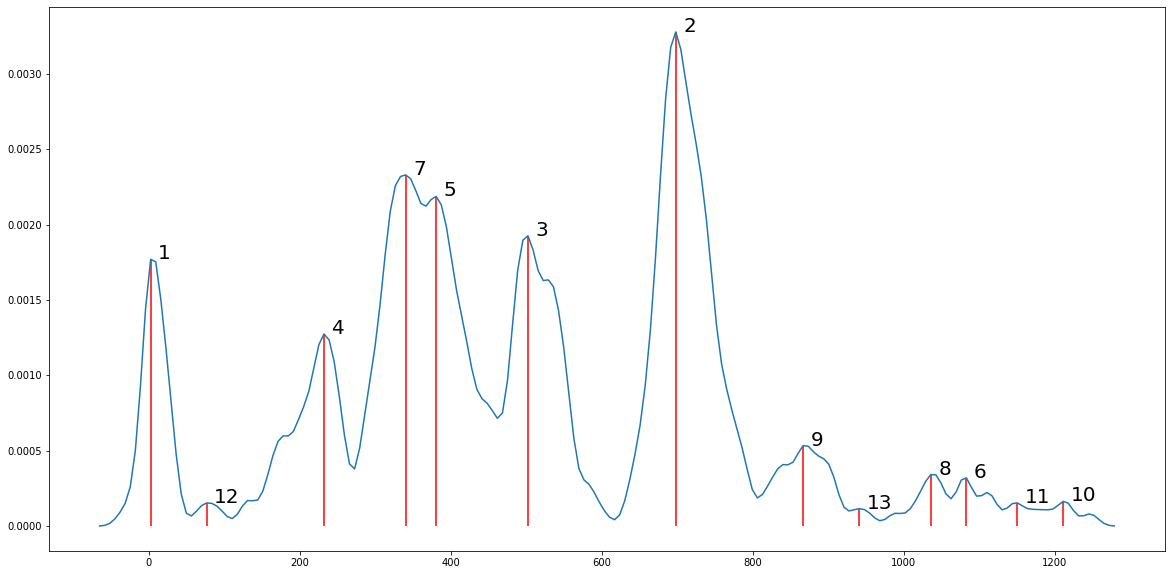

[2, 698, 502, 232, 380, 1083, 340, 1035, 866, 1211, 1150, 76, 941]


array([[    0,  -696,  -500,  -230,  -378, -1081,  -338, -1033,  -864,
        -1209, -1148,   -74,  -939],
       [  696,     0,   196,   466,   318,  -385,   358,  -337,  -168,
         -513,  -452,   622,  -243],
       [  500,  -196,     0,   270,   122,  -581,   162,  -533,  -364,
         -709,  -648,   426,  -439],
       [  230,  -466,  -270,     0,  -148,  -851,  -108,  -803,  -634,
         -979,  -918,   156,  -709],
       [  378,  -318,  -122,   148,     0,  -703,    40,  -655,  -486,
         -831,  -770,   304,  -561],
       [ 1081,   385,   581,   851,   703,     0,   743,    48,   217,
         -128,   -67,  1007,   142],
       [  338,  -358,  -162,   108,   -40,  -743,     0,  -695,  -526,
         -871,  -810,   264,  -601],
       [ 1033,   337,   533,   803,   655,   -48,   695,     0,   169,
         -176,  -115,   959,    94],
       [  864,   168,   364,   634,   486,  -217,   526,  -169,     0,
         -345,  -284,   790,   -75],
       [ 1209,   513,   709,

In [76]:
# 0: 2-0; 1: 2-1; 2: 1-0
datum = all_intervals
num_bins = int((max(datum) - min(datum)) / 10)
print('accuracy', (max(datum) - min(datum)) / num_bins)
h = plt.hist(datum, num_bins,
             density=True,
             histtype='bar',
             facecolor='r',
             alpha=0.5)

kde = sns.kdeplot(np.array(datum), bw_method=0.04)

xs = kde.get_lines()[0].get_xdata(orig=True)
ys = kde.get_lines()[0].get_ydata(orig=True)
plt.figure(figsize=(20, 10))
plt.plot(xs, ys)

peaks = get_peaks(xs, ys, 2)
x = draw_peaks(peaks, xs, ys, 20, 40)

int_ps = [int(p) for p in x]
print(int_ps)
(np.array(int_ps).reshape(-1, 1) - int_ps)

In [77]:
import pyOSC3

client = pyOSC3.OSCClient()
client.connect(('127.0.0.1', 57120))

def send_msg(note, cur_timbre, out_bus_idx):
    try:
        msg = pyOSC3.OSCMessage()
        msg.setAddress("/synths")
        msg.append([note, cur_timbre, out_bus_idx])
        client.send(msg)
    except Exception as e:
        pass


In [107]:
# notes = [1, 698, 502, 232, 380, 1083, 340, 1035, 866, 1211, 1150, 76, 941]
# scale = [0, 76, 232, 340, 380, 502, 698, 866, 942, 1035, 1083, 1150, 1211]
scale = [0, 76, 232, 340, 386, 502, 702, 866, 942, 1035, 1088, 1150, 1211]
scale.sort()
print(scale)
scale = np.array(scale)
print(scale[1:] - scale[:-1])

for n in scale:
    hz = calc_hz(n, 440)
    send_msg(hz, 0, 0)
    time.sleep(0.5)


[0, 76, 232, 340, 386, 502, 702, 866, 942, 1035, 1088, 1150, 1211]
[ 76 156 108  46 116 200 164  76  93  53  62  61]


In [175]:
phi = (1 + 5 ** 0.5) / 2
c1 = ratio_to_cents(phi, 1)
scale = []
for k in [1, 2, 3, 4]:
    scale += [ratio_to_cents(phi*k, 1)]
    if k != 1:
        scale += [c1 - ratio_to_cents(phi*k, 1)]
scale = [p % c1 for p in scale]
scale += [c1]
print(scale)
# scale = [0, 121.54, 196.66, 318.21, 439.75, 514.87, 636.42, 711.54, 833.09]
scale.sort()
print(scale)
scale = np.array(scale)
print(scale[1:] - scale[:-1])
# phi_chords = [[0, 2, 6], [0, 3, 5], [0, 4]]
for n in scale:
# for ch in phi_chords:
#     hzs = [calc_hz(scale[n], 440) for n in ch]
    hzs = [calc_hz(n, 440)]
    for hz in hzs:
        send_msg(hz, 0, 0)
    time.sleep(1.0)

# scale = [int(p) for p in scale]
# print(scale)
# (np.array(scale).reshape(-1, 1) - scale)

[0.0, 366.90970364325904, 466.1805927134817, 235.77440815190528, 597.3158882048357, 733.819407286518, 99.270889070223, 833.0902963567409]
[0.0, 99.270889070223, 235.77440815190528, 366.90970364325904, 466.1805927134817, 597.3158882048357, 733.819407286518, 833.0902963567409]
[ 99. 137. 131.  99. 131. 137.  99.]


In [166]:
# Bohlen 833-scale
scale = [0, 99.27, 235.77, 366.91, 466.18, 597.32, 733.82, 833.09]
scale.sort()
print(scale)
scale = np.array(scale)
print(scale[1:] - scale[:-1])

# phi_chords = [[0, 2, 6], [0, 3, 5], [0, 4]]
for n in scale:
# for ch in phi_chords:
#     hzs = [calc_hz(scale[n], 440) for n in ch]
    hzs = [calc_hz(n, 440)]
    for hz in hzs:
        send_msg(hz, 0, 0)
    time.sleep(1.0)

# scale = [int(p) for p in scale]
# print(scale)
# (np.array(scale).reshape(-1, 1) - scale)

[0, 99.27, 235.77, 366.91, 466.18, 597.32, 733.82, 833.09]
[ 99. 136. 131.  99. 131. 136.  99.]


In [199]:
scale_bot = [1508, 1604, 1691, 1731, 1775, 1874, 2065]
scale_mid = [2070, 2226, 2333, 2409, 2476, 2545, 2728]
scale_top = [2089, 2218, 2410, 2547, 2620, 2727, 2794, 2884]
scale_mrg = [1508, 1604, 1691, 1731, 1775, 1874, 2070, 2226, 2333, 2409, 2476, 2545, 2620, 2728, 2794, 2884]
# scale_ton = [2070, 2226, 2333, 2409, 2476, 2545, 2620, 2728, 2794, 2884]
scale = scale_mrg
scale = np.array(scale)
scale -= scale[0]
print(scale)
print(scale[1:] - scale[:-1])

for n in scale:
    hz = calc_hz(n, 440)
    send_msg(hz, 0, 0)
    time.sleep(0.5)

time.sleep(0.5)

scale = list(scale)
scale.reverse()
for n in scale:
    hz = calc_hz(n, 440)
    send_msg(hz, 0, 0)
    time.sleep(0.5)


[   0   96  183  223  267  366  562  718  825  901  968 1037 1112 1220
 1286 1376]
[ 96  87  40  44  99 196 156 107  76  67  69  75 108  66  90]
